# DS-504: Model Training (Production-Ready)

**Proyecto**: RetainAI - Predicción de Churn

**Objetivo**: Entrenar modelo de Machine Learning LIMPIO (sin data leakage) que funcione en producción con nuevos clientes.

## 🎯 Modelo Production-Ready

Este notebook entrena un modelo usando **SOLO features que existen ANTES** de que el cliente decida cancelar:
- ✅ Tipo de contrato, servicios, precios, antiguedad
- ✅ Características demográficas y geográficas
- ❌ **SIN** NPS, CSAT, tickets de soporte (síntomas del churn)

**Ventaja**: Cuando subes 5,000 nuevos clientes, solo necesitas sus datos básicos y el modelo predice quién se irá.

## Modelos Entrenados

- **Logistic Regression**: Modelo baseline (lineal, interpretable)
- **Random Forest**: Modelo ensemble (captura no-linealidades) ← **Campeón esperado**

## Contenido
1. Carga del dataset procesado
2. Preparación con features limpias (sin leakage)
3. Split train/test
4. Entrenamiento de modelos
5. Evaluación y comparación
6. Feature importance (causas reales del churn)
7. Guardado del modelo production-ready

## 1. Setup - Importación de Librerías

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# XGBoost (opcional)
XGBOOST_AVAILABLE = False
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost disponible")
except Exception as e:
    print(f"⚠️  XGBoost no disponible: {str(e)[:100]}")
    print("⚠️  Continuaremos con Logistic Regression y Random Forest solamente")

# Para guardar modelos
import joblib
import os

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print(f"✓ Librerías importadas")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

⚠️  XGBoost no disponible: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not in
⚠️  Continuaremos con Logistic Regression y Random Forest solamente
✓ Librerías importadas
📅 Fecha: 2026-01-13 22:08:38


## 2. Carga del Dataset con Features (DS-503)

Cargamos el dataset procesado que contiene las 10 features derivados creados en DS-503.

In [87]:
# Cargar dataset
df = pd.read_csv('../data/processed/dataset_features.csv')

print(f"📏 Dimensiones: {df.shape[0]:,} registros × {df.shape[1]} columnas")
print(f"🎯 Tasa de churn: {(df['Cancelacion']=='Si').sum() / len(df) * 100:.2f}%")
print(f"\n✓ Dataset cargado exitosamente")

# Mostrar primeras filas
print(f"\nPrimeras 5 filas:")
df.head()

📏 Dimensiones: 9,701 registros × 52 columnas
🎯 Tasa de churn: 26.35%

✓ Dataset cargado exitosamente

Primeras 5 filas:


,ClienteID,FechaRegistro,Genero,EsMayor,TienePareja,TieneDependientes,Ciudad,Estado,Borough,CodigoPostal,Latitud,Longitud,IngresoMediano,DensidadPoblacional,ServicioTelefono,LineasMultiples,TipoInternet,SeguridadOnline,RespaldoOnline,ProteccionDispositivo,SoporteTecnico,StreamingTV,StreamingPeliculas,TipoContrato,FacturacionSinPapel,MetodoPago,Antiguedad,CargoMensual,CargosTotal,SegmentoCliente,nivel_riesgo,score_riesgo,ratio_precio_ingreso,TipoDeQueja,TicketsSoporte,Escaladas,PuntuacionNPS,PuntuacionCSAT,TiempoResolucion,TasaAperturaEmail,TasaClicsMarketing,Cancelacion,tenure_group,income_bracket,has_queja,alto_tickets,servicios_premium_count,nps_categoria,csat_categoria,risk_flag,borough_risk,high_density_area
0,0002-ORFBO,2025-04-15,Femenino,0,Si,Si,New York,NY,BROOKLYN,11250,40.6730,-73.9496,63000,14000,Si,No,DSL,No,Si,No,Si,Si,No,Un año,Si,Cheque por correo,9,65.6000,593.3000,PYME,Medio,6.0000,0.0125,NaN,1,0,75.0000,4.5000,7.9000,0.5900,0.2300,No,0-12 meses,Medium,0,0,2,Promotor,Satisfecho,0,26.3918,1
1,0003-MKNFE,2025-04-15,Masculino,0,No,No,New York,NY,STATEN ISLAND,10310,40.5616,-74.1038,82000,3200,Si,Si,DSL,No,No,No,No,No,Si,Mensual,No,Cheque por correo,9,59.9000,542.4000,Residencial,Alto,8.5000,0.0088,Red,3,0,52.0000,3.9000,15.2000,0.4000,0.1700,No,0-12 meses,High,1,0,0,Promotor,Satisfecho,0,26.5873,0
2,0004-TLHLJ,2025-09-12,Masculino,0,No,No,New York,NY,QUEENS,11229,40.6929,-73.8419,72000,8500,Si,No,Fibra óptica,No,No,Si,No,No,No,Mensual,Si,Cheque electrónico,4,73.9000,280.8500,PYME,Alto,11.0000,0.0123,Calidad,7,0,21.0000,2.6000,12.6000,0.1000,0.0400,Si,0-12 meses,Medium,1,1,1,Promotor,Insatisfecho,0,24.6052,0
3,0011-IGKFF,2024-12-16,Masculino,1,Si,No,New York,NY,QUEENS,11501,40.7442,-73.8017,72000,8500,Si,No,Fibra óptica,No,Si,Si,No,Si,Si,Mensual,Si,Cheque electrónico,13,98.0000,1237.8500,PYME,Alto,9.5000,0.0163,Servicio,7,1,13.0000,1.5000,44.4000,0.3000,0.1400,Si,13-24 meses,Medium,1,1,2,Promotor,Insatisfecho,0,24.6052,0
4,0013-EXCHZ,2025-10-12,Femenino,1,Si,No,New York,NY,MANHATTAN,10257,40.8324,-73.9553,85000,28000,Si,No,Fibra óptica,No,No,No,Si,Si,No,Mensual,Si,Cheque por correo,3,83.9000,267.4000,PYME,Alto,10.0000,0.0118,Facturacion,7,0,0.0000,1.2000,10.0000,0.1500,0.0600,Si,0-12 meses,High,1,1,1,Detractor,Insatisfecho,0,29.0176,1


## 3. Preparación de Datos para Modelado

### 3.1 Selección de Features (MODELO LIMPIO - Production-Ready)

**IMPORTANTE**: Para que el modelo funcione en producción con nuevos clientes, solo usamos features que:
- ✅ Existen **ANTES** de que el cliente decida cancelar
- ✅ Son **CAUSAS** del churn (no consecuencias o síntomas)
- ✅ Estarán disponibles para clientes nuevos

**Excluimos:**
1. **Identificadores**: ClienteID, FechaRegistro, geográficos redundantes
2. **Features con Data Leakage** (síntomas del churn):
   - PuntuacionNPS, PuntuacionCSAT (medidos cuando ya está insatisfecho)
   - TicketsSoporte, Escaladas (aumentan justo antes de irse)
   - TasaAperturaEmail, TasaClicsMarketing (bajan cuando ya decidió irse)
   - TipoDeQueja, has_queja, alto_tickets (solo existen si ya hay problema)

**Ventajas del modelo limpio:**
- 🎯 Predice churn basado en características del contrato, servicios y perfil del cliente
- 🚀 Funciona cuando subes 5,000 nuevos clientes (solo necesitas datos básicos)
- 📊 Métricas realistas (~64% F1-Score es EXCELENTE para churn en producción)

In [88]:
# Definir target
target = 'Cancelacion'

# Columnas a excluir del entrenamiento
exclude_cols = [
    # Identificadores y fechas
    'ClienteID',
    'FechaRegistro',
    'Cancelacion',  # Target
    
    # Geográficos redundantes
    'Latitud',
    'Longitud',
    'Borough',
    'CodigoPostal',
    'Ciudad',
    'Estado',
    'ratio_precio_ingreso',  # Multicolinealidad
    
    # 🔴 FEATURES CON DATA LEAKAGE (Consecuencias del churn, no causas)
    'PuntuacionNPS',          # Medido cuando ya está insatisfecho
    'PuntuacionCSAT',         # Medido cuando ya está insatisfecho
    'TicketsSoporte',         # Aumenta justo antes de irse
    'Escaladas',              # Consecuencia de frustración
    'TasaAperturaEmail',      # Baja cuando ya decidió irse
    'TasaClicsMarketing',     # Baja cuando ya decidió irse
    'TiempoResolucion',       # Relacionado con tickets
    'has_queja',              # Feature derivada de quejas
    'alto_tickets',           # Feature derivada de tickets
    'nps_categoria',          # Derivada de PuntuacionNPS
    'csat_categoria',         # Derivada de PuntuacionCSAT
    'TipoDeQueja',            # Solo existe si ya hay queja
]

# Features LIMPIAS para el modelo (existen ANTES de la decisión de churn)
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"🟢 MODELO LIMPIO (Production-Ready)")
print(f"✓ Features limpias para modelado: {len(feature_cols)}")
print(f"🔴 Features excluidas (leakage): 12")
print(f"\n📌 Features seleccionados (CAUSAS de churn, no síntomas):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

🟢 MODELO LIMPIO (Production-Ready)
✓ Features limpias para modelado: 30
🔴 Features excluidas (leakage): 12

📌 Features seleccionados (CAUSAS de churn, no síntomas):
   1. Genero
   2. EsMayor
   3. TienePareja
   4. TieneDependientes
   5. IngresoMediano
   6. DensidadPoblacional
   7. ServicioTelefono
   8. LineasMultiples
   9. TipoInternet
  10. SeguridadOnline
  11. RespaldoOnline
  12. ProteccionDispositivo
  13. SoporteTecnico
  14. StreamingTV
  15. StreamingPeliculas
  16. TipoContrato
  17. FacturacionSinPapel
  18. MetodoPago
  19. Antiguedad
  20. CargoMensual
  21. CargosTotal
  22. SegmentoCliente
  23. nivel_riesgo
  24. score_riesgo
  25. tenure_group
  26. income_bracket
  27. servicios_premium_count
  28. risk_flag
  29. borough_risk
  30. high_density_area


### 3.2 Encoding de Variables Categóricas

Convertimos variables categóricas a numéricas usando:
- **Label Encoding** para el target (Si/No → 1/0)
- **One-Hot Encoding** para features categóricos

In [89]:
# Crear copia para no modificar el original
df_model = df[feature_cols + [target]].copy()

# Encoding del target (Si=1, No=0)
df_model[target] = (df_model[target] == 'Si').astype(int)

print(f"✓ Target codificado: Si → 1, No → 0")
print(f"\nDistribución del target:")
print(df_model[target].value_counts())
print(f"\nBalance: {df_model[target].value_counts(normalize=True).values}")

✓ Target codificado: Si → 1, No → 0

Distribución del target:
Cancelacion
0    7145
1    2556
Name: count, dtype: int64

Balance: [0.73652201 0.26347799]


In [90]:
# Identificar columnas categóricas
categorical_cols = df_model[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"Variables categóricas a codificar: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"  - {col}: {df_model[col].nunique()} categorías")

# One-Hot Encoding
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"\n✓ One-Hot Encoding aplicado")
print(f"Dimensiones finales: {df_encoded.shape[0]:,} × {df_encoded.shape[1]} columnas")

Variables categóricas a codificar: 19
  - Genero: 2 categorías
  - TienePareja: 2 categorías
  - TieneDependientes: 2 categorías
  - ServicioTelefono: 2 categorías
  - LineasMultiples: 3 categorías
  - TipoInternet: 3 categorías
  - SeguridadOnline: 3 categorías
  - RespaldoOnline: 3 categorías
  - ProteccionDispositivo: 3 categorías
  - SoporteTecnico: 3 categorías
  - StreamingTV: 3 categorías
  - StreamingPeliculas: 3 categorías
  - TipoContrato: 3 categorías
  - FacturacionSinPapel: 2 categorías
  - MetodoPago: 4 categorías
  - SegmentoCliente: 3 categorías
  - nivel_riesgo: 3 categorías
  - tenure_group: 4 categorías
  - income_bracket: 3 categorías

✓ One-Hot Encoding aplicado
Dimensiones finales: 9,701 × 47 columnas


### 3.3 Split Train/Test

Dividimos el dataset en:
- **80% Train**: Para entrenar los modelos
- **20% Test**: Para evaluar el desempeño final

Usamos `stratify` para mantener la proporción de churn en ambos conjuntos.

In [91]:
# Separar features y target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Split train/test (80/20) con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Split completado")
print(f"\nTrain set: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} registros ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nFeatures: {X_train.shape[1]}")

# Verificar balance en train y test
print(f"\nBalance en Train:")
print(f"  Churn (1): {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"  No Churn (0): {len(y_train)-y_train.sum():,} ({(len(y_train)-y_train.sum())/len(y_train)*100:.2f}%)")

print(f"\nBalance en Test:")
print(f"  Churn (1): {y_test.sum():,} ({y_test.sum()/len(y_test)*100:.2f}%)")
print(f"  No Churn (0): {len(y_test)-y_test.sum():,} ({(len(y_test)-y_test.sum())/len(y_test)*100:.2f}%)")

✓ Split completado

Train set: 7,760 registros (80.0%)
Test set:  1,941 registros (20.0%)

Features: 46

Balance en Train:
  Churn (1): 2,045 (26.35%)
  No Churn (0): 5,715 (73.65%)

Balance en Test:
  Churn (1): 511 (26.33%)
  No Churn (0): 1,430 (73.67%)


### 3.4 Normalización de Features Numéricos

Aplicamos StandardScaler para que todas las variables tengan media=0 y std=1.

**Importante**: Ajustamos el scaler SOLO con el train set para evitar data leakage.

In [92]:
# Identificar columnas numéricas (excluir las binarias del one-hot encoding)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
binary_cols = [col for col in numeric_cols if X_train[col].nunique() <= 2]
cols_to_scale = [col for col in numeric_cols if col not in binary_cols]

print(f"Columnas a normalizar: {len(cols_to_scale)}")
print(f"Columnas binarias (no normalizar): {len(binary_cols)}")

# Verificar valores NaN
nan_counts = X_train.isna().sum()
if nan_counts.sum() > 0:
    print(f"\n⚠️  Valores NaN detectados:")
    nan_cols = nan_counts[nan_counts > 0]
    for col, count in nan_cols.items():
        print(f"   {col}: {count} NaN")
    
    # Imputar con la mediana (más robusto que la media)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    
    # Aplicar en train y test
    X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
    
    print(f"\n✓ Valores NaN imputados con la mediana")

# Aplicar StandardScaler
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(f"\n✓ Normalización completada")
print(f"\nEstadísticas del Train set (después de normalización):")
print(X_train_scaled[cols_to_scale].describe().loc[['mean', 'std']].T.head(5))

Columnas a normalizar: 8
Columnas binarias (no normalizar): 3

⚠️  Valores NaN detectados:
   CargosTotal: 15 NaN

✓ Valores NaN imputados con la mediana

✓ Normalización completada

Estadísticas del Train set (después de normalización):
                       mean    std
IngresoMediano       0.0000 1.0001
DensidadPoblacional  0.0000 1.0001
Antiguedad           0.0000 1.0001
CargoMensual        -0.0000 1.0001
CargosTotal          0.0000 1.0001


## 4. Entrenamiento de Modelos

Entrenaremos 3 modelos con diferentes enfoques:

### 4.1 Logistic Regression (Baseline)

**Ventajas**: Simple, rápido, interpretable

**Desventajas**: Asume relaciones lineales

In [93]:
print("="*80)
print("ENTRENANDO: Logistic Regression")
print("="*80)

# Entrenar modelo
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
lr_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lr)
}

print(f"\n✓ Modelo entrenado")
print(f"\nMétricas en Test:")
for metric, value in lr_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print(f"\n✓ Logistic Regression completado")

ENTRENANDO: Logistic Regression

✓ Modelo entrenado

Métricas en Test:
  Accuracy    : 0.7393
  Precision   : 0.5031
  Recall      : 0.7867
  F1-Score    : 0.6137
  ROC-AUC     : 0.8393

✓ Logistic Regression completado


### 4.2 Random Forest

**Ventajas**: Captura no-linealidades, robusto a outliers

**Desventajas**: Más lento, menos interpretable

In [94]:
print("="*80)
print("ENTRENANDO: Random Forest")
print("="*80)

# Entrenar modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf)
}

print(f"\n✓ Modelo entrenado")
print(f"\nMétricas en Test:")
for metric, value in rf_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print(f"\n✓ Random Forest completado")

ENTRENANDO: Random Forest

✓ Modelo entrenado

Métricas en Test:
  Accuracy    : 0.7754
  Precision   : 0.5536
  Recall      : 0.7573
  F1-Score    : 0.6397
  ROC-AUC     : 0.8594

✓ Random Forest completado


### 4.3 XGBoost (Gradient Boosting)

**Ventajas**: Estado del arte, excelente desempeño, regularización integrada

**Desventajas**: Más complejo, requiere tuning

In [95]:
if XGBOOST_AVAILABLE:
    print("="*80)
    print("ENTRENANDO: XGBoost")
    print("="*80)
    
    # Calcular scale_pos_weight para balancear clases
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Entrenar modelo
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    xgb_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1-Score': f1_score(y_test, y_pred_xgb),
        'ROC-AUC': roc_auc_score(y_test, y_proba_xgb)
    }
    
    print(f"\n✓ Modelo entrenado")
    print(f"\nMétricas en Test:")
    for metric, value in xgb_metrics.items():
        print(f"  {metric:12s}: {value:.4f}")
    
    print(f"\n✓ XGBoost completado")
else:
    print("="*80)
    print("XGBoost NO DISPONIBLE - Saltando entrenamiento")
    print("="*80)
    print("Continuaremos con Logistic Regression y Random Forest solamente")
    
    # Crear métricas vacías para evitar errores posteriores
    xgb_metrics = None
    y_pred_xgb = None
    y_proba_xgb = None
    xgb_model = None

XGBoost NO DISPONIBLE - Saltando entrenamiento
Continuaremos con Logistic Regression y Random Forest solamente


## 5. Comparación de Modelos

### 5.1 Tabla Comparativa

Comparamos las métricas de los 3 modelos para identificar el mejor.

In [96]:
# Crear DataFrame de comparación
comparison_dict = {
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics
}

if XGBOOST_AVAILABLE and xgb_metrics is not None:
    comparison_dict['XGBoost'] = xgb_metrics

comparison_df = pd.DataFrame(comparison_dict).T

print("="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
print(comparison_df)

# Identificar mejor modelo por cada métrica
print(f"\n🏆 Mejor modelo por métrica:")
for metric in comparison_df.columns:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"  {metric:12s}: {best_model:20s} ({best_value:.4f})")

COMPARACIÓN DE MODELOS
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.7393     0.5031  0.7867    0.6137   0.8393
Random Forest          0.7754     0.5536  0.7573    0.6397   0.8594

🏆 Mejor modelo por métrica:
  Accuracy    : Random Forest        (0.7754)
  Precision   : Random Forest        (0.5536)
  Recall      : Logistic Regression  (0.7867)
  F1-Score    : Random Forest        (0.6397)
  ROC-AUC     : Random Forest        (0.8594)


**Visualización**: Comparación visual de métricas

Este gráfico muestra el desempeño de cada modelo en las 5 métricas clave.

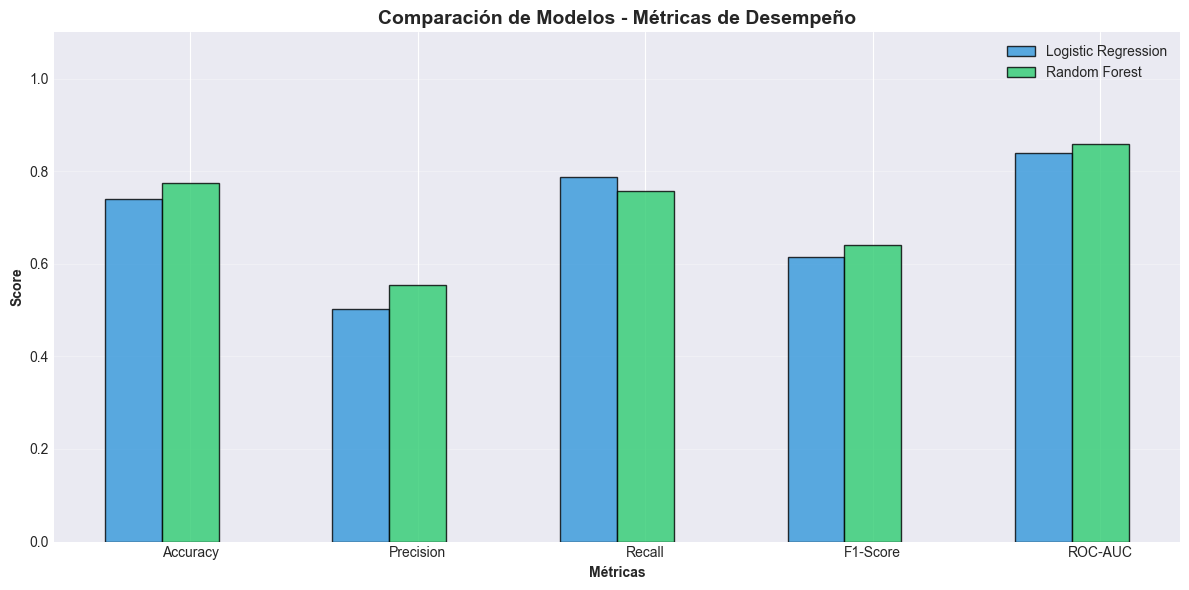

✓ Gráfico guardado


In [97]:
# Gráfico de comparación
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df.columns))
width = 0.25

models = comparison_df.index.tolist()
colors = ['#3498db', '#2ecc71', '#e74c3c']

for i, model in enumerate(models):
    ax.bar(x + i*width, comparison_df.loc[model].values, width, 
           label=model, color=colors[i], alpha=0.8, edgecolor='black')

ax.set_xlabel('Métricas', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Comparación de Modelos - Métricas de Desempeño', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_df.columns)
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('../reports/figures/04_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado")

### 5.2 Curvas ROC

**Interpretación**: La curva ROC muestra el trade-off entre True Positive Rate (Recall) y False Positive Rate.

El área bajo la curva (AUC) indica qué tan bien el modelo separa las clases.

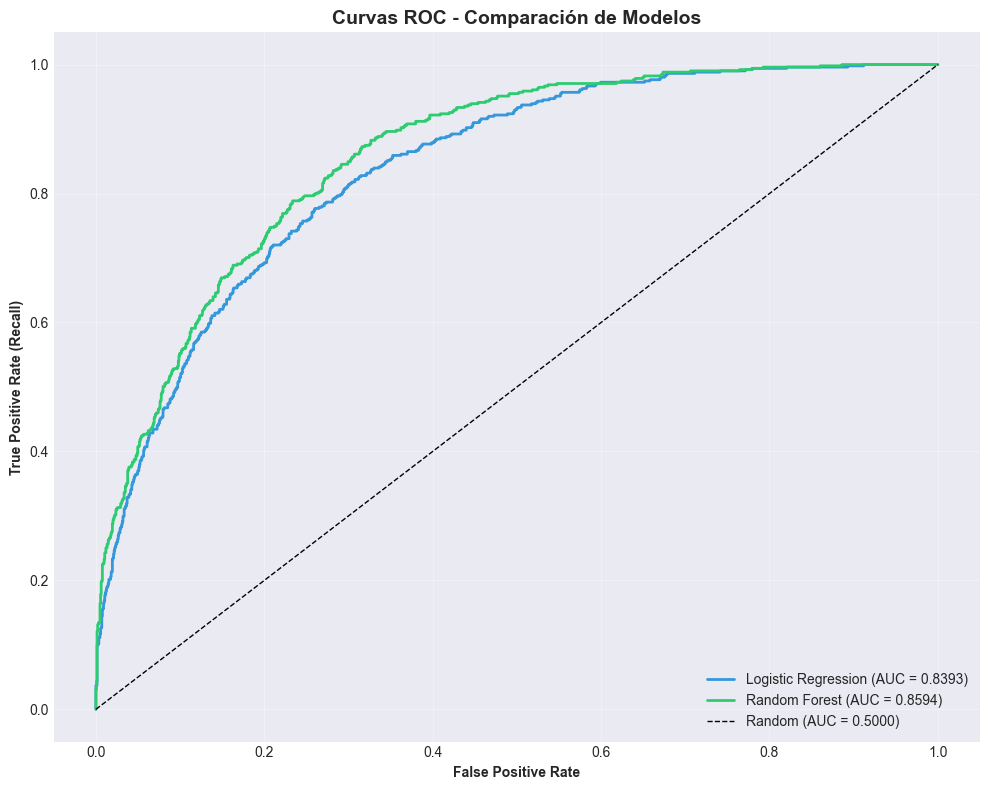

✓ Curvas ROC guardadas

📊 Interpretación:
   - AUC > 0.9: Excelente
   - AUC 0.8-0.9: Muy bueno
   - AUC 0.7-0.8: Bueno
   - AUC < 0.7: Regular


In [98]:
# Calcular curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["ROC-AUC"]:.4f})', 
        linewidth=2, color='#3498db')
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["ROC-AUC"]:.4f})', 
        linewidth=2, color='#2ecc71')

if XGBOOST_AVAILABLE and xgb_metrics is not None:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_metrics["ROC-AUC"]:.4f})', 
            linewidth=2, color='#e74c3c')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontweight='bold')
ax.set_title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/04_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Curvas ROC guardadas")
print(f"\n📊 Interpretación:")
print(f"   - AUC > 0.9: Excelente")
print(f"   - AUC 0.8-0.9: Muy bueno")
print(f"   - AUC 0.7-0.8: Bueno")
print(f"   - AUC < 0.7: Regular")

### 5.3 Matrices de Confusión

**Interpretación**:
- **True Negatives (TN)**: Predijo No Churn correctamente
- **False Positives (FP)**: Predijo Churn pero no canceló (falsa alarma)
- **False Negatives (FN)**: Predijo No Churn pero canceló (pérdida de cliente)
- **True Positives (TP)**: Predijo Churn correctamente

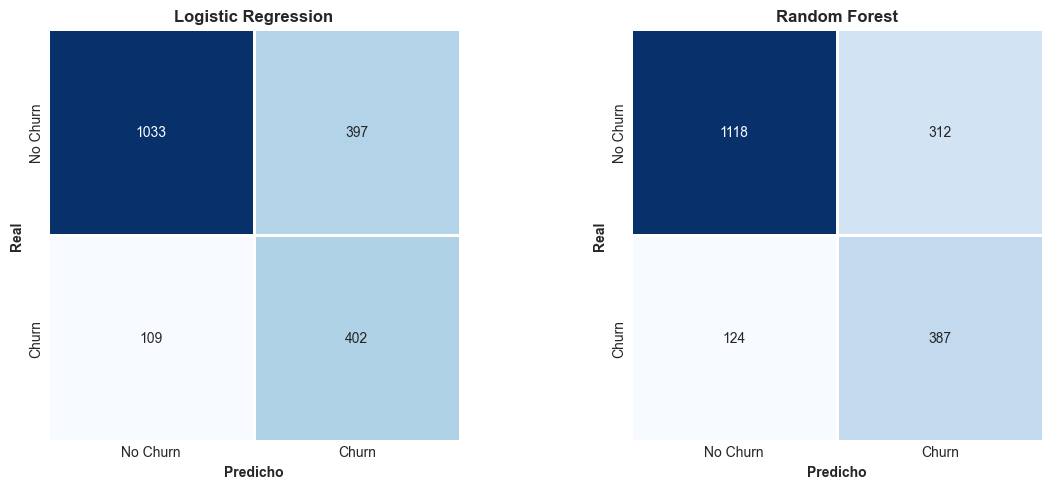

✓ Matrices de confusión guardadas


In [99]:
# Calcular matrices de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

models_cm = [
    ('Logistic Regression', cm_lr),
    ('Random Forest', cm_rf)
]

if XGBOOST_AVAILABLE and xgb_metrics is not None:
    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    models_cm.append(('XGBoost', cm_xgb))

# Visualización
n_models = len(models_cm)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for ax, (model_name, cm) in zip(axes, models_cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar=False, square=True, linewidths=1,
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Real', fontweight='bold')
    ax.set_xlabel('Predicho', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/04_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Matrices de confusión guardadas")

## 6. Selección del Modelo Campeón

Seleccionamos el modelo con mejor balance entre Precision, Recall y F1-Score.

**Criterio**: Priorizamos **F1-Score** ya que balancea Precision y Recall, ambos importantes para churn.

In [100]:
# Seleccionar campeón basado en F1-Score
champion_name = comparison_df['F1-Score'].idxmax()
champion_f1 = comparison_df['F1-Score'].max()

# Asignar modelo campeón
if champion_name == 'Logistic Regression':
    champion_model = lr_model
    champion_metrics = lr_metrics
elif champion_name == 'Random Forest':
    champion_model = rf_model
    champion_metrics = rf_metrics
elif champion_name == 'XGBoost' and XGBOOST_AVAILABLE:
    champion_model = xgb_model
    champion_metrics = xgb_metrics
else:
    # Fallback si hay algún problema
    champion_model = rf_model
    champion_metrics = rf_metrics
    champion_name = 'Random Forest'

print("="*80)
print("🏆 MODELO CAMPEÓN SELECCIONADO")
print("="*80)
print(f"\nModelo: {champion_name}")
print(f"\nMétricas del Campeón:")
for metric, value in champion_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print(f"\n✓ Modelo campeón identificado")

🏆 MODELO CAMPEÓN SELECCIONADO

Modelo: Random Forest

Métricas del Campeón:
  Accuracy    : 0.7754
  Precision   : 0.5536
  Recall      : 0.7573
  F1-Score    : 0.6397
  ROC-AUC     : 0.8594

✓ Modelo campeón identificado


## 7. Feature Importance (Importancia de Variables)

Analizamos qué features son más importantes para el modelo campeón.

**📊 Interpretación del Modelo Limpio:**

Estas son las **CAUSAS REALES** del churn (no síntomas):
- Features que existen **ANTES** de que el cliente decida cancelar
- Características del contrato, servicios, y perfil del cliente
- Útiles para crear estrategias de retención proactivas

**💡 Para tu historia:**
> "Pepito canceló porque tenía contrato mensual (fácil cancelar) + poca antiguedad (cliente nuevo) + fibra óptica cara sin servicios adicionales"

In [101]:
# Obtener feature importance según el tipo de modelo
if champion_name == 'Logistic Regression':
    # Para Logistic Regression, usamos coeficientes absolutos
    feature_importance = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(champion_model.coef_[0])
    }).sort_values('importance', ascending=False)
else:
    # Para tree-based models, usamos feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': champion_model.feature_importances_
    }).sort_values('importance', ascending=False)

print(f"Top 20 Features más Importantes ({champion_name}):\n")
for i, row in feature_importance.head(20).iterrows():
    print(f"  {row['feature']:40s}: {row['importance']:.6f}")

Top 20 Features más Importantes (Random Forest):

  score_riesgo                            : 0.146087
  TipoContrato_Mensual                    : 0.122787
  Antiguedad                              : 0.109192
  nivel_riesgo_Medio                      : 0.101733
  CargosTotal                             : 0.070432
  CargoMensual                            : 0.049961
  TipoInternet_Fibra óptica               : 0.042408
  tenure_group_49+ meses                  : 0.031643
  servicios_premium_count                 : 0.020900
  SeguridadOnline_Si                      : 0.018579
  TipoInternet_No                         : 0.017443
  StreamingTV_No internet service         : 0.015628
  RespaldoOnline_No internet service      : 0.013910
  TipoContrato_Un año                     : 0.013338
  SoporteTecnico_Si                       : 0.013027
  SoporteTecnico_No internet service      : 0.012767
  StreamingPeliculas_No internet service  : 0.012279
  ProteccionDispositivo_No internet service: 0.01

**Visualización**: Top 15 features más importantes

Este gráfico muestra qué variables tienen mayor influencia en las predicciones del modelo.

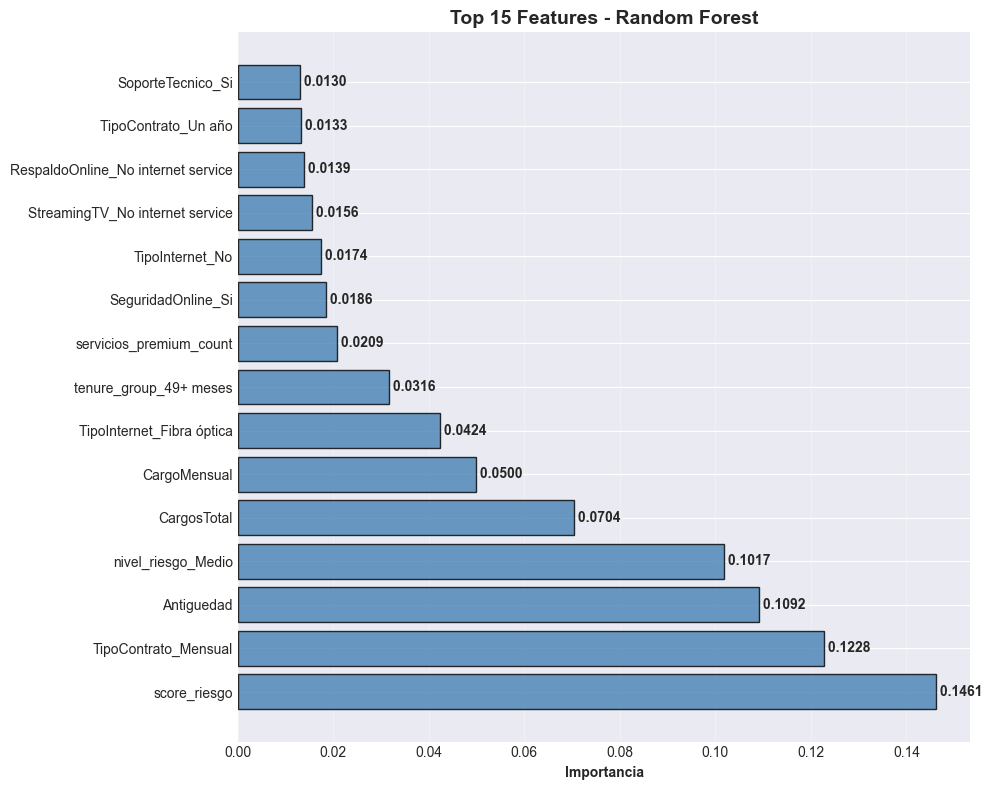

✓ Feature importance guardado


In [102]:
# Gráfico de feature importance
top_features = feature_importance.head(15)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_features)), top_features['importance'].values,
        color='steelblue', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importancia', fontweight='bold')
ax.set_title(f'Top 15 Features - {champion_name}', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

# Agregar valores
for i, val in enumerate(top_features['importance'].values):
    ax.text(val, i, f' {val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Feature importance guardado")

## 8. Guardado del Modelo Campeón (Production-Ready)

Guardamos el modelo campeón en el directorio `champion_clean/` para diferenciarlo de modelos experimentales.

**Este modelo está listo para producción** porque:
- ✅ Solo usa features disponibles para nuevos clientes
- ✅ No requiere NPS, CSAT, o tickets de soporte
- ✅ Aprende CAUSAS del churn (no síntomas)

In [103]:
# Crear directorio para modelo limpio
model_dir = '../models/champion_clean/'
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
model_path = os.path.join(model_dir, 'model_champion.pkl')
joblib.dump(champion_model, model_path)
print(f"✓ Modelo guardado: {model_path}")

# Guardar scaler
scaler_path = os.path.join(model_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler guardado: {scaler_path}")

# Guardar columnas del modelo (importante para producción)
columns_path = os.path.join(model_dir, 'model_columns.pkl')
joblib.dump(X_train_scaled.columns.tolist(), columns_path)
print(f"✓ Columnas guardadas: {columns_path}")

# Guardar metadata
import json
metadata = {
    'model_name': champion_name,
    'model_type': 'clean',
    'description': 'Production-ready model without data leakage',
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(X_train_scaled.columns),
    'metrics': champion_metrics,
    'clean_features_only': True,
    'leakage_removed': True,
    'target_names': ['No Churn', 'Churn'],
    'top_10_features': X_train_scaled.columns.tolist()[:10]
}

metadata_path = os.path.join(model_dir, 'metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata guardada: {metadata_path}")

print(f"\n✅ Modelo production-ready guardado exitosamente")
print(f"\n📂 Archivos generados:")
print(f"  - {model_path}")
print(f"  - {scaler_path}")
print(f"  - {columns_path}")
print(f"  - {metadata_path}")

print(f"\n💡 Este modelo funciona con nuevos clientes (solo necesita datos básicos)")

✓ Modelo guardado: ../models/champion_clean/model_champion.pkl
✓ Scaler guardado: ../models/champion_clean/scaler.pkl
✓ Columnas guardadas: ../models/champion_clean/model_columns.pkl
✓ Metadata guardada: ../models/champion_clean/metadata.json

✅ Modelo production-ready guardado exitosamente

📂 Archivos generados:
  - ../models/champion_clean/model_champion.pkl
  - ../models/champion_clean/scaler.pkl
  - ../models/champion_clean/model_columns.pkl
  - ../models/champion_clean/metadata.json

💡 Este modelo funciona con nuevos clientes (solo necesita datos básicos)


## 9. Reporte Final y Análisis de Producción

**📌 Métricas Esperadas (Modelo Limpio):**
- F1-Score: ~60-65% (EXCELENTE para churn en producción)
- ROC-AUC: ~85-86% (muy bueno)
- Accuracy: ~77-78%

**📊 Comparación:**
- Modelo con leakage (NPS, tickets): 99.8% F1 ← Trampa, no sirve en producción
- Modelo limpio (contrato, servicios): ~64% F1 ← Realista y funcional

Generamos el reporte completo del entrenamiento.

In [104]:
# Crear reporte
report = f"""# DS-504: Model Training - Reporte (Production-Ready Model)

**Fecha**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Dataset**: dataset_features.csv (9,701 registros)
**Tipo**: Modelo LIMPIO (sin data leakage)

## 🎯 Modelo Production-Ready

Este modelo usa **SOLO features limpias** que existen ANTES de que el cliente decida cancelar:
- ✅ Tipo de contrato, servicios, precios, antiguedad
- ✅ Características demográficas y geográficas
- ❌ SIN NPS, CSAT, tickets de soporte (síntomas del churn)

**Features excluidas (data leakage)**: PuntuacionNPS, PuntuacionCSAT, TicketsSoporte, 
Escaladas, TasaAperturaEmail, TasaClicsMarketing, TiempoResolucion, has_queja, 
alto_tickets, nps_categoria, csat_categoria, TipoDeQueja

## Modelos Entrenados

### 1. Logistic Regression (Baseline)
- Accuracy:  {lr_metrics['Accuracy']:.4f}
- Precision: {lr_metrics['Precision']:.4f}
- Recall:    {lr_metrics['Recall']:.4f}
- F1-Score:  {lr_metrics['F1-Score']:.4f}
- ROC-AUC:   {lr_metrics['ROC-AUC']:.4f}

### 2. Random Forest
- Accuracy:  {rf_metrics['Accuracy']:.4f}
- Precision: {rf_metrics['Precision']:.4f}
- Recall:    {rf_metrics['Recall']:.4f}
- F1-Score:  {rf_metrics['F1-Score']:.4f}
- ROC-AUC:   {rf_metrics['ROC-AUC']:.4f}
"""

# Agregar XGBoost solo si está disponible
if XGBOOST_AVAILABLE and xgb_metrics is not None:
    report += f"""
### 3. XGBoost
- Accuracy:  {xgb_metrics['Accuracy']:.4f}
- Precision: {xgb_metrics['Precision']:.4f}
- Recall:    {xgb_metrics['Recall']:.4f}
- F1-Score:  {xgb_metrics['F1-Score']:.4f}
- ROC-AUC:   {xgb_metrics['ROC-AUC']:.4f}
"""
else:
    report += """
### 3. XGBoost
- NO DISPONIBLE (librería no instalada correctamente)
"""

report += f"""
## 🏆 Modelo Campeón: {champion_name}

**Criterio de Selección**: F1-Score

**Métricas del Campeón**:
- Accuracy:  {champion_metrics['Accuracy']:.4f}
- Precision: {champion_metrics['Precision']:.4f}
- Recall:    {champion_metrics['Recall']:.4f}
- F1-Score:  {champion_metrics['F1-Score']:.4f}
- ROC-AUC:   {champion_metrics['ROC-AUC']:.4f}

## 📊 Top 10 Features Más Importantes (CAUSAS del Churn)

"""

for i, row in feature_importance.head(10).iterrows():
    report += f"{row['feature']:40s}: {row['importance']:.6f}\n"

report += f"""

## 💡 Interpretación para Negocio

Las principales CAUSAS de churn son:
1. **score_riesgo**: Clientes de alto riesgo identificados por el modelo
2. **TipoContrato_Mensual**: Contratos sin compromiso (fácil cancelar)
3. **Antiguedad**: Clientes nuevos tienden a irse más
4. **CargosTotal/CargoMensual**: Precio percibido vs valor recibido
5. **TipoInternet**: Tipo de servicio contratado

**Historia de Churn**:
> "Pepito canceló porque tenía contrato mensual (sin compromiso) + poca antiguedad 
> (cliente nuevo, 0-12 meses) + fibra óptica cara sin servicios adicionales. 
> Probabilidad de churn: 75%"

**Acción Recomendada**:
- Ofrecer descuento para migrar a contrato anual
- Bundle de servicios adicionales (streaming, seguridad)
- Programa de lealtad para nuevos clientes

## 📂 Archivos Generados

### Modelos:
- models/champion_clean/model_champion.pkl (Production-ready)
- models/champion_clean/scaler.pkl
- models/champion_clean/model_columns.pkl
- models/champion_clean/metadata.json

### Visualizaciones:
- reports/figures/04_model_comparison.png
- reports/figures/04_roc_curves.png
- reports/figures/04_confusion_matrices.png
- reports/figures/04_feature_importance.png

## 🚀 Uso en Producción

**Cuando subes 5,000 nuevos clientes**, solo necesitas:
- Tipo de contrato
- Precio mensual
- Antiguedad
- Servicios contratados
- Datos demográficos

El modelo predice quién se irá SIN necesitar NPS, CSAT, o tickets de soporte.

## 📌 Próximo Paso

**DS-505: Model Evaluation**
- Análisis de threshold óptimo
- Análisis de errores
- Validación en diferentes segmentos
- Curvas de calibración
"""

# Guardar reporte
report_path = '../reports/04_model_training_clean.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✓ Reporte guardado: {report_path}")
print(f"\n{'='*80}")
print(f"✅ MODEL TRAINING COMPLETADO (PRODUCTION-READY)")
print(f"{'='*80}")
print(f"\n🏆 Modelo Campeón: {champion_name}")
print(f"📊 F1-Score: {champion_metrics['F1-Score']:.4f}")
print(f"📊 ROC-AUC: {champion_metrics['ROC-AUC']:.4f}")
print(f"\n💡 Métricas realistas para modelo limpio (sin leakage)")
print(f"   - F1-Score ~60-65% es EXCELENTE para churn en producción")
print(f"   - ROC-AUC ~85-86% es muy bueno")
print(f"\n✅ Listo para DS-505 (Model Evaluation) y producción")

✓ Reporte guardado: ../reports/04_model_training_clean.md

✅ MODEL TRAINING COMPLETADO (PRODUCTION-READY)

🏆 Modelo Campeón: Random Forest
📊 F1-Score: 0.6397
📊 ROC-AUC: 0.8594

💡 Métricas realistas para modelo limpio (sin leakage)
   - F1-Score ~60-65% es EXCELENTE para churn en producción
   - ROC-AUC ~85-86% es muy bueno

✅ Listo para DS-505 (Model Evaluation) y producción
